# Диагностика диабетической ретинопатии по изображению сетчатки глаза с помощью нейронной сети

Представьте себе возможность обнаружить слепоту до ее наступления. 

Миллионы людей страдают от диабетической ретинопатии -- основной причины слепоты среди взрослых людей трудоспособного возраста. Глазная больница Аравинд в Индии надеется обнаружить и предотвратить это заболевание среди людей, живущих в сельских районах, где трудно провести медицинское обследование. 

В настоящее время специалисты Аравинд выезжают в эти сельские районы, чтобы делать снимки, а затем полагаются на высококвалифицированных врачей для просмотра изображений и постановки диагноза. Их цель - масштабировать свои усилия с помощью технологий; получить возможность автоматически проверять изображения на наличие заболевания и предоставлять информацию о том, насколько серьезным может быть состояние.
    
На платформе kaggle было проведено соревнование с целью создания модели машинного обучения для ускорения выявления заболевания.  
    https://www.kaggle.com/c/aptos2019-blindness-detection. 

## Цель проекта:
1. Решить задачу классификации

2. Разработать ассистента врача для определения диагноза: т.е. помимо классификации реализовать систему, которая объясняет почему именно такое решение было принято, подсвечивая те области на изображении, которые влияют на постановку диагноза. 

Таким образом, даже если модель ошиблась в степени тяжести заболевания, локализация проблемы может помочь врачам.

In [1]:
import os
import shutil
import re
import math

import pandas as pd
import numpy as np

import cv2

from random import shuffle, sample, randint
from glob import glob

from sklearn.model_selection import train_test_split

from keras.applications import VGG16


from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from keras import metrics

from keras.models import load_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix



from matplotlib import pyplot as plt
%matplotlib inline

import keras.backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## Чтение данных

In [2]:
base_image_dir = '/home/tgorlenko/Project'
train_dir = os.path.join(base_image_dir, 'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df.head()

id_code  diagnosis                                               path
0  000c1434d8d7          2  /home/tgorlenko/Project/train_images/000c1434d...
1  001639a390f0          4  /home/tgorlenko/Project/train_images/001639a39...
2  0024cdab0c1e          1  /home/tgorlenko/Project/train_images/0024cdab0...
3  002c21358ce6          0  /home/tgorlenko/Project/train_images/002c21358...
4  005b95c28852          0  /home/tgorlenko/Project/train_images/005b95c28...

Посмотрим на баланс классов

In [3]:
df.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

Выборка несбалансированая

# Деление выборки

Поделим выорку на обучение, тест и валидацию:

In [3]:
image_train, im_test, y_train, y_tt = train_test_split(np.array(df.path), 
                                                            np.array(df.diagnosis), 
                                                            test_size=0.3,
                                                            random_state=123, 
                                                            stratify=df.diagnosis)


In [4]:
image_test, image_val, y_test, y_val = train_test_split(im_test, 
                                                        y_tt, 
                                                        test_size=100,
                                                        random_state=123, 
                                                        stratify=y_tt)

Посмотрим какие образцы попали в обучающую, тестовую и валидационную выборки:

In [5]:
image_train[:5]

array(['/home/tgorlenko/Project/train_images/69df7ade0575.png',
       '/home/tgorlenko/Project/train_images/f952ad2e4356.png',
       '/home/tgorlenko/Project/train_images/00e4ddff966a.png',
       '/home/tgorlenko/Project/train_images/1df0431bfa73.png',
       '/home/tgorlenko/Project/train_images/4e1e252317b5.png'],
      dtype=object)

In [6]:
image_test[:5]

array(['/home/tgorlenko/Project/train_images/76cfe8967f7d.png',
       '/home/tgorlenko/Project/train_images/5e52c9fe676f.png',
       '/home/tgorlenko/Project/train_images/4a4cb731f91a.png',
       '/home/tgorlenko/Project/train_images/8446826853d0.png',
       '/home/tgorlenko/Project/train_images/e59c5f345bb0.png'],
      dtype=object)

In [7]:
image_val[:5]

array(['/home/tgorlenko/Project/train_images/41960d5f58c2.png',
       '/home/tgorlenko/Project/train_images/5cbe88914a72.png',
       '/home/tgorlenko/Project/train_images/c5bec7f1e5f3.png',
       '/home/tgorlenko/Project/train_images/28f98cfe3858.png',
       '/home/tgorlenko/Project/train_images/ace2281f00c4.png'],
      dtype=object)

Проверим, что в тренировочной и тестовой выборке отношение классов одинаковое

In [8]:
_, class_instances = np.unique(y_train, return_counts=True)
class_instances

array([1263,  259,  699,  135,  207])

In [9]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([492, 101, 273,  53,  80]))

In [10]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3, 4]), array([50, 10, 27,  5,  8]))

Запомним сколько элементов в самом маленьком классе

In [11]:
MIN_NUM = min(class_instances)
MIN_NUM

135

Создадим словарь вида {путь_картинки : класс, ...} для быстрого доступа к метке класса по пути картинки

In [12]:
label_for_path_in_train = dict(zip(image_train, y_train))
label_for_path_in_val = dict(zip(image_val, y_val))
label_for_path_in_test = dict(zip(image_test, y_test))

# Борьба с несбалансированностью классов

**ИДЕЯ:** Из каждого класса возьмем случайныс образом MIN_NUM элементов, перемешаем их и на этой сбалансированной выборке будем обучаться. Перед каждой эпохой будем создавать новую сбалансированную обучающую выборку.

Для этого создадим словарь вида:
{метка класса 0: список картинок,
метка класса 1: список картинок, ...}

In [13]:
sorted_paths_by_class = {}
for path, label in zip(image_train, y_train):
    if label in sorted_paths_by_class:
        sorted_paths_by_class[label].append(path)
    else:
        sorted_paths_by_class[label] = [path]

Создадим новую обучающую сбалансированную выборку:

In [14]:
def get_balanсe_train(dict_of_sorted_paths_train, len_sample=MIN_NUM):
    result = []
    for label, path_list in dict_of_sorted_paths_train.items():
        random_paths = sample(path_list, len_sample)   # случайным образом выбираем MIN_NUM число путей картинок
        result.extend(random_paths)
    shuffle(result)                          # перемешиваем выборку
    return result

# Предобработка данных:

In [15]:
IMG_SIZE = (224, 224)  # размер входного изображения сети
NUM_CLASSES = 5        # число классов
EPSILON = 1          # с такой вероятностью делаем поворот картинки

## Кодирование целевой переменной

Идею возьмем из статьи Eibe Frank and Mark Hall. “A Simple Approach to Ordinal Classification”  

(https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf)

Так как между классами существует порядок, то закодируем классы следующим образом:

0  ->  \[0, 0, 0, 0 \]  
1  ->  \[1, 0, 0, 0 \]  
2  ->  \[1, 1, 0, 0 \]  
3  ->  \[1, 1, 1, 0 \]  
4  ->  \[1, 1, 1, 1 \]

In [16]:
def target_code(label, num_classes=NUM_CLASSES):
    vec = np.zeros((num_classes-1))
    vec[:label] = 1
    return vec

In [17]:
def batch_of_true_label(vect):
    '''
    По батчу из закодированной метки возвращает батч реальных меток класса
    '''
    return np.sum(vect, axis=-1)

## Обратное преобразование для получения метки класса

In [18]:
def get_label_pred(prediction, probability=False):
    '''
    По предсказанию модели получить метку классу (метку, которой соответствует наивысшая вероятность)

    prediction = [a, b, c, d]
    vec1 - vec0 = [p_0, p_1, p_2, p_3, p_4],  где p_i -- вероятность принадлежности классу i

    p_0 = 1 - a
    p_1 = a - b
    p_2 = b - c
    p_3 = c - d
    p_4 = d
    '''

    batch_size, m = prediction.shape
    vec1 = np.ones((batch_size, m+1))
    vec0 = np.zeros((batch_size, m+1))

    vec1[:,1:] = prediction
    vec0[:,:-1] = prediction
    
    if probability:
        return vec1 - vec0   # вектор вероятности принадлежности классу
    else:
        return np.argmax(vec1 - vec0, axis=1)

## Работа с изображением

In [19]:
def rotate_image(image, angle):
    '''
    Функция, которая возвращает картинку, которую повернули на заданный угол
    '''
    col, row, _ = image.shape
    center = tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (row, col))
    return new_image

In [20]:
def crop_image_from_gray(img,tol=7):
    '''
    Обрезает темные края на картинке
    '''
    if img.ndim == 2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [21]:
def circle_crop(path, img_size=IMG_SIZE, sigmaX=10, is_train=False, is_plot=False, blur=True):   
    """
    Делает круговую обрезку вокруг центра изображения  
    """    
    
    
    img = cv2.imread(path)
    
    if is_train:                           # делаем поворот картинки только при обучении
        if np.random.random() < EPSILON:   # определяем будем ли поворачивать картинку
            angle = randint(0, 359)
            img = rotate_image(img, angle);
    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    if blur:
        img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX), -4 ,128)
    
    img = cv2.resize(img, img_size)
    
    if is_plot:
        return img
    else:
        return preprocess_input(img)   # предобработка для VGG16

## Генераторы для подгрузки данных

In [22]:
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(dict_label_for_path, batch_size=64, is_train=True, files=image_train):
    while True:
        if is_train:
            files = get_balanсe_train(sorted_paths_by_class)   # Создать сбалансированную выборку
            shuffle(files)
        
        for k in range(math.ceil(len(files) / batch_size)):   # округляем до ближайшего целого вверх
            i = k * batch_size                                # k -- номер батча в проходе                      
            j = i + batch_size
            if j > len(files):
                j = len(files)
            x = np.array([circle_crop(path, is_train=is_train) for path in files[i:j]]) # картинки в виде матрицы
            label = np.array([dict_label_for_path[path] for path in files[i:j]])     # метки класса
            y = np.array([target_code(lab) for lab in label])      # кодирование целевой переменной
            y_mask = np.zeros((y.shape[0],28,28,1))  # фиктивный выход для маски
            yield ({'input_1': x}, {'output_1': y, 'output_2': y_mask})

In [23]:
# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            
            yield np.array([circle_crop(path)])

# Визуализация примеров для обучения

Посмотрим как выглядят исходные данные

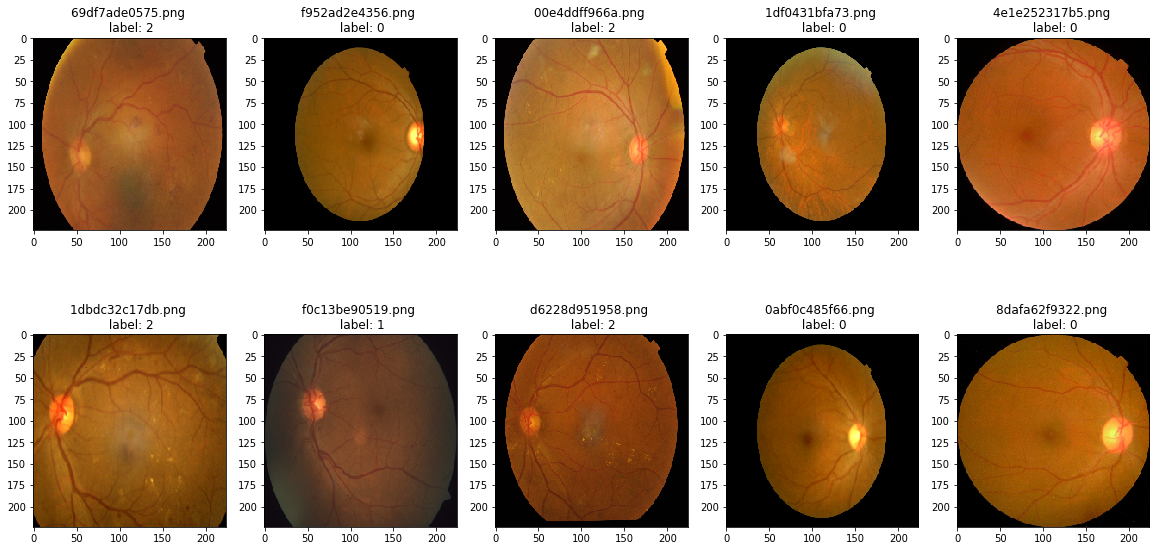

In [24]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(image_train[:10], 1):
    subplot = fig.add_subplot(math.ceil(i / 5), 5, i)
    plt.imshow(cv2.resize(plt.imread(path), IMG_SIZE));
    subplot.set_title('{} \n label: {}'.format(os.path.basename(path), label_for_path_in_train[path]))

А так они выглядят после предобработки:

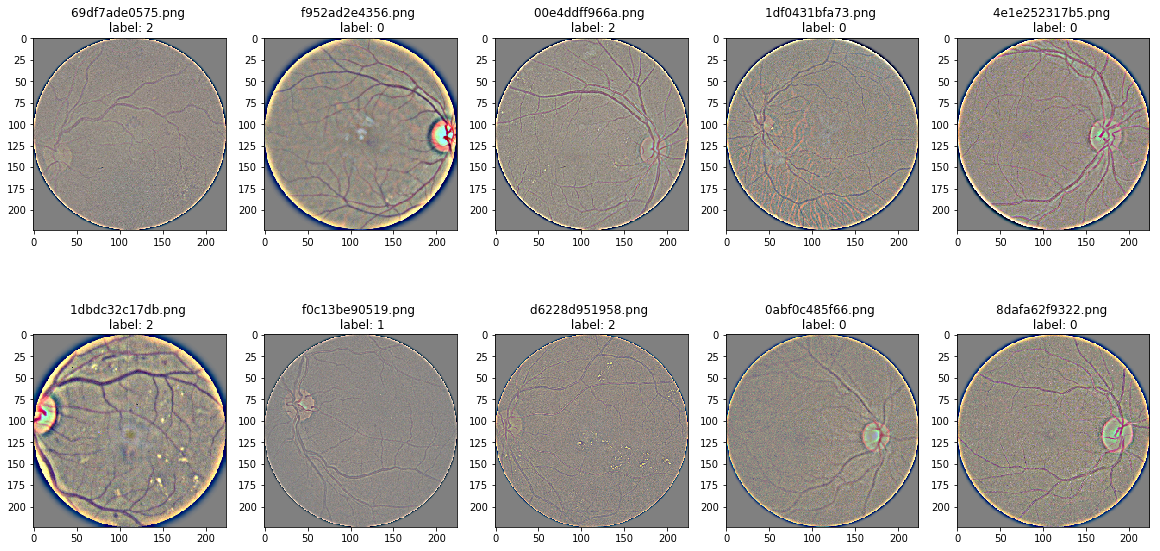

In [25]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(image_train[:10], 1):
    subplot = fig.add_subplot(math.ceil(i / 5), 5, i)
    plt.imshow(circle_crop(path, is_plot=True));
    subplot.set_title('{} \n label: {}'.format(os.path.basename(path), label_for_path_in_train[path]))

Выполним поворот на случайный угол первой картинки:

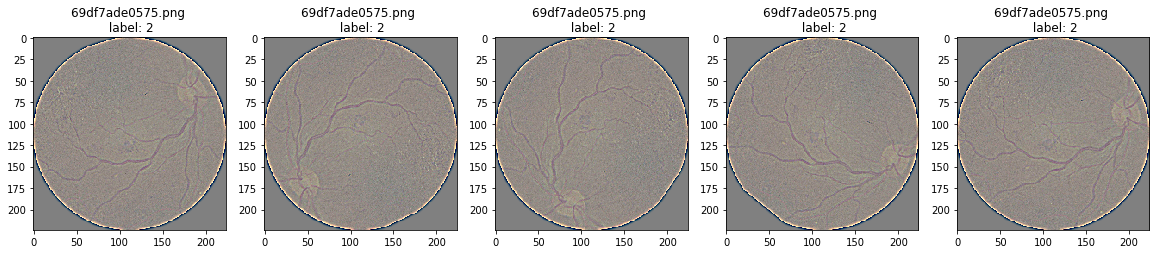

In [26]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(np.array([image_train[0]]*5), 1):
    subplot = fig.add_subplot(math.ceil(i / 5), 5, i)
    plt.imshow(circle_crop(path, is_train=True, is_plot=True));
    subplot.set_title('{} \n label: {}'.format(os.path.basename(path), label_for_path_in_train[path]))

# Метрики качества

In [27]:
def quadratic_kappa(actuals, preds, N=NUM_CLASSES):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

In [28]:
def all_metrics(prediction):
    print('Каппа = {:.4f}'.format(quadratic_kappa(get_true_labels_in_all_test(image_test), 
                                                  get_label_pred(prediction))))
    print('\n-----------------------------------------\n')
    
    print('Точность: {:.4f}'.format(precision_score(get_true_labels_in_all_test(image_test), 
                                        get_label_pred(prediction), 
                                        average='weighted')))

    print('\nТочность в срезе по классам:')
    print('0: {:.4f}\n1: {:.4f}\n2: {:.4f}\n3: {:.4f}\n4: {:.4f}'.format(*precision_score(
        get_true_labels_in_all_test(image_test), get_label_pred(prediction), average=None)))
    
    print('\n-----------------------------------------\n')
    
    print('Полнота: {:.4f}'.format(recall_score(get_true_labels_in_all_test(image_test), 
                                    get_label_pred(prediction), average='weighted')))

    print('\nПолнота в срезе по классам:')
    print('0: {:.4f}\n1: {:.4f}\n2: {:.4f}\n3: {:.4f}\n4: {:.4f}'.format(*recall_score(
        get_true_labels_in_all_test(image_test), get_label_pred(prediction), average=None)))
    
    print('\n-----------------------------------------\n')
    
    print('Энтропия: {:.4f}'.format(log_loss(get_true_labels_in_all_test(image_test),
                                             get_label_pred(prediction, True))))

## Класс для подчета метрики на валидации

In [29]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []    
    
    def on_epoch_end(self, batch, logs={}):

        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = model_mask.predict(X_val)[0]

        true_labels = np.array((batch_of_true_label(y_val))).astype(int)  # вектор, состоящий из меток класса
        pred_labels = get_label_pred(y_predict).astype(int)
        
        kappa = quadratic_kappa(true_labels, pred_labels)
        

        self._data.append(kappa)
        
        print('kappa_val = {:.4f}'.format(kappa))
        return

    def get_data(self):
        return self._data

In [30]:
metrics0 = Metrics()

# Строим модель

Загружаем преобученную на датасете 'ImageNet' модель VGG16 

In [31]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

Instructions for updating:
Colocations handled automatically by placer.


In [32]:
# фиксируем все веса предобученной сети кроме последнего блока 
set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [33]:
out_block2 = vgg16.get_layer('block2_pool').output    # выход блока 2

# ответвление на маску
y = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block6_conv1')(out_block2)
y = layers.BatchNormalization(name='block_6_batch_norm1')(y)
y = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block6_conv2')(y)
y = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block6_pool')(y)
y = layers.BatchNormalization(name='block_6_batch_norm2')(y)
mask = layers.Convolution2D(1, 1, 1, activation='sigmoid', name='mask')(y)  # выход блока 6
output_2 = layers.Lambda(lambda x: x, name='output_2')(mask)  # выход маски
                           
mask_256 = layers.Lambda(lambda x: K.repeat_elements(x, 256, axis=-1))(mask)  # размножим маску на 256 каналов

out_block3 = vgg16.get_layer('block3_pool').output    # выход блока 3


x = layers.Multiply()([out_block3, mask_256])

x = vgg16.get_layer('block4_conv1')(x)  #  блок 4
x = vgg16.get_layer('block4_conv2')(x)
x = vgg16.get_layer('block4_conv3')(x)
x = vgg16.get_layer('block4_pool')(x)

x = vgg16.get_layer('block5_conv1')(x)  #  блок 5
x = vgg16.get_layer('block5_conv2')(x)
x = vgg16.get_layer('block5_conv3')(x)
x = vgg16.get_layer('block5_pool')(x)


x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
output_1 = layers.Dense(NUM_CLASSES-1, activation='sigmoid', name='output_1')(x)

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="sigmoid", name="mask")`
  from ipykernel import kernelapp as app


In [34]:
model_mask = models.Model(inputs=vgg16.input, outputs=[output_1, output_2])

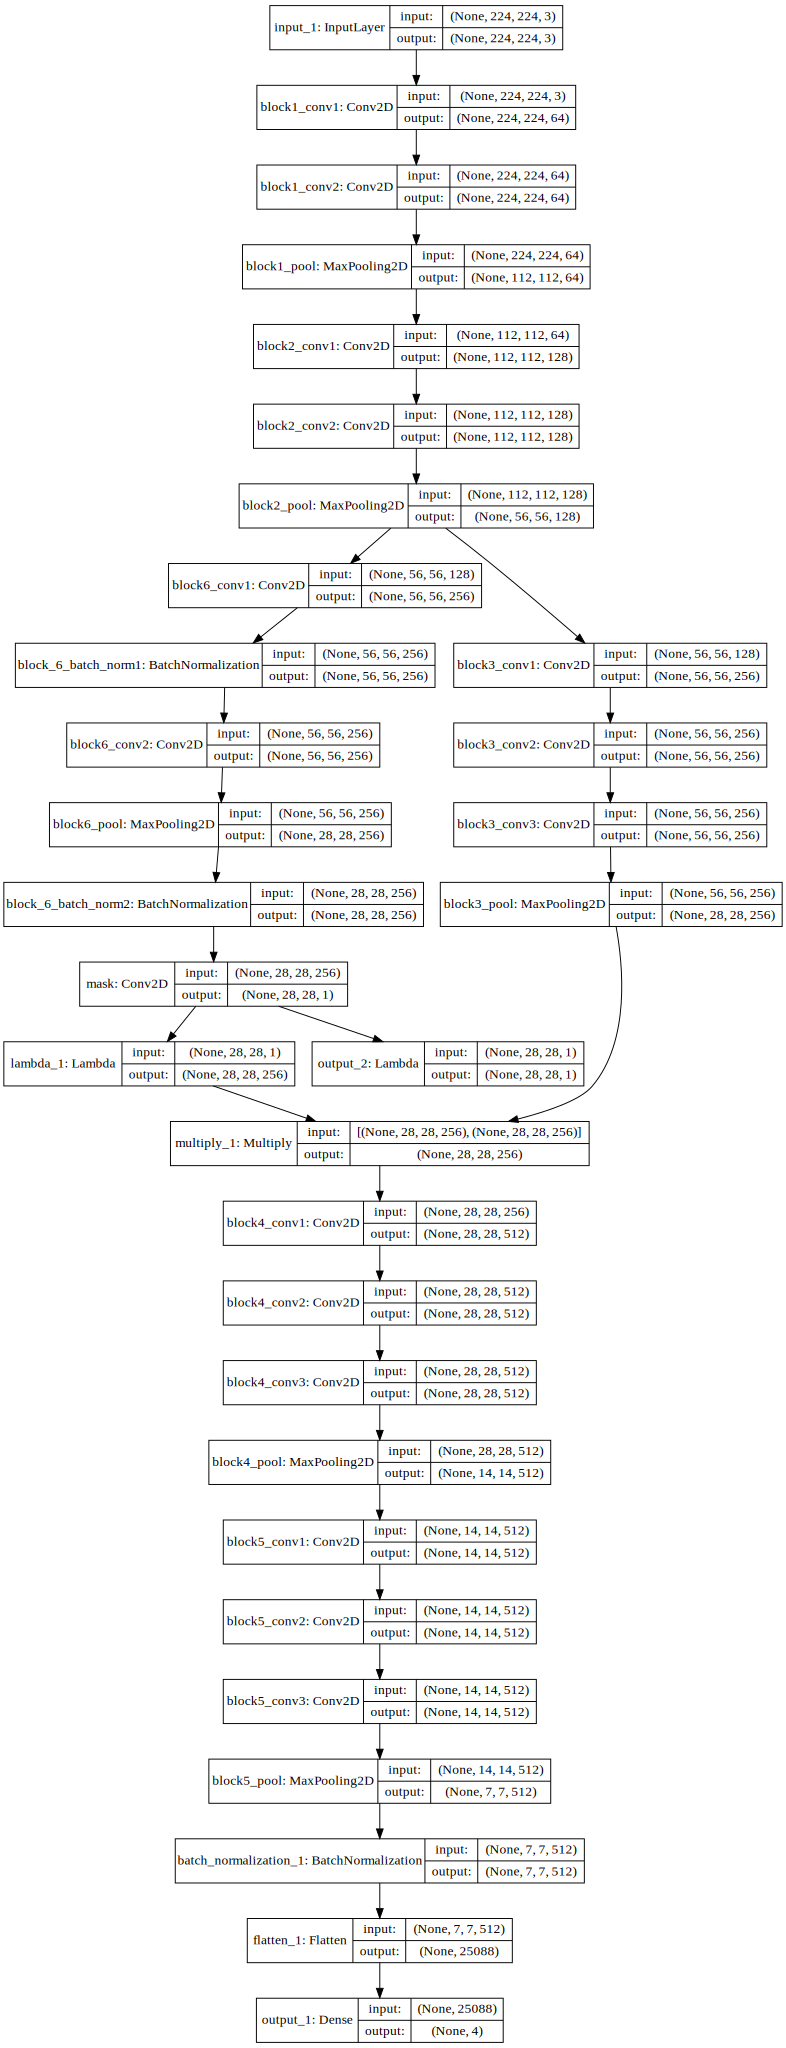

In [35]:
SVG(model_to_dot(model_mask, show_shapes=True).create(prog='dot', format='svg'))

In [36]:
model_mask.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [37]:
def print_layer_trainable():
    for layer in model_mask.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable() 

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
True:	block6_conv1
True:	block_6_batch_norm1
True:	block6_conv2
False:	block3_conv1
True:	block6_pool
False:	block3_conv2
True:	block_6_batch_norm2
False:	block3_conv3
True:	mask
False:	block3_pool
True:	lambda_1
True:	multiply_1
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	batch_normalization_1
True:	flatten_1
True:	output_1
True:	output_2


In [38]:
def loss_mask(y_true, y_pred):
    return K.sum(y_pred)

In [39]:
model_mask.compile(optimizer=Adam(lr=0.001),
                   loss={'output_1': 'binary_crossentropy', 'output_2': loss_mask},
                   loss_weights={'output_1': 1, 'output_2': 0.0001})

In [49]:
validation_data = next(fit_generator(label_for_path_in_val,
                                     batch_size=len(image_val), 
                                     is_train=False,
                                     files=image_val))

Запускаем обучение

In [50]:
history = model_mask.fit_generator(fit_generator(dict_label_for_path=label_for_path_in_train, is_train=True),  # данные читаем функцией-генератором
        steps_per_epoch=11,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data,
        callbacks=[metrics0,
            ModelCheckpoint(filepath='{epoch:02d}.hdf5',
                            verbose=1,
                            save_best_only=False),
            ReduceLROnPlateau(monitor='output_1_loss',
                              factor=0.7,
                              verbose=1,
                              patience=8)]
                               )

Epoch 1/100
11/11 [==============================] - 279s 25s/step - loss: 3.0028 - output_1_loss: 1.5512 - output_2_loss: 14464.1094 - val_loss: 7.1143 - val_output_1_loss: 4.6062 - val_output_2_loss: 24562.1641
kappa_val = 0.2582

Epoch 00001: saving model to 01.hdf5
Epoch 2/100
11/11 [==============================] - 251s 23s/step - loss: 1.5522 - output_1_loss: 0.6198 - output_2_loss: 9309.6377 - val_loss: 1.5058 - val_output_1_loss: 0.8981 - val_output_2_loss: 5976.8867
kappa_val = 0.5657

Epoch 00002: saving model to 02.hdf5
Epoch 3/100
11/11 [==============================] - 253s 23s/step - loss: 1.2107 - output_1_loss: 0.4601 - output_2_loss: 7493.6514 - val_loss: 1.3613 - val_output_1_loss: 1.0196 - val_output_2_loss: 3265.1660
kappa_val = 0.3087

Epoch 00003: saving model to 03.hdf5
Epoch 4/100
11/11 [==============================] - 255s 23s/step - loss: 1.1076 - output_1_loss: 0.4890 - output_2_loss: 6174.8311 - val_loss: 0.7741 - val_output_1_loss: 0.5331 - val_output_2

kappa_val = 0.7277

Epoch 00031: saving model to 31.hdf5
Epoch 32/100
11/11 [==============================] - 249s 23s/step - loss: 0.4104 - output_1_loss: 0.3390 - output_2_loss: 713.5339 - val_loss: 1.1019 - val_output_1_loss: 1.0736 - val_output_2_loss: 309.4968
kappa_val = 0.2123

Epoch 00032: saving model to 32.hdf5
Epoch 33/100
11/11 [==============================] - 253s 23s/step - loss: 0.3903 - output_1_loss: 0.3215 - output_2_loss: 685.9637 - val_loss: 0.4244 - val_output_1_loss: 0.3843 - val_output_2_loss: 368.3295
kappa_val = 0.4963

Epoch 00033: saving model to 33.hdf5
Epoch 34/100
11/11 [==============================] - 252s 23s/step - loss: 0.4257 - output_1_loss: 0.3519 - output_2_loss: 736.6604 - val_loss: 0.9202 - val_output_1_loss: 0.8900 - val_output_2_loss: 343.9400
kappa_val = 0.2689

Epoch 00034: saving model to 34.hdf5
Epoch 35/100
11/11 [==============================] - 246s 22s/step - loss: 0.3823 - output_1_loss: 0.3167 - output_2_loss: 656.1555 - val_los

11/11 [==============================] - 251s 23s/step - loss: 0.2938 - output_1_loss: 0.2614 - output_2_loss: 326.0056 - val_loss: 0.3415 - val_output_1_loss: 0.3247 - val_output_2_loss: 163.2032
kappa_val = 0.7925

Epoch 00092: saving model to 92.hdf5
Epoch 93/100
11/11 [==============================] - 252s 23s/step - loss: 0.3022 - output_1_loss: 0.2723 - output_2_loss: 301.7485 - val_loss: 0.2421 - val_output_1_loss: 0.2247 - val_output_2_loss: 160.1672
kappa_val = 0.7399

Epoch 00093: saving model to 93.hdf5
Epoch 94/100
11/11 [==============================] - 250s 23s/step - loss: 0.2955 - output_1_loss: 0.2661 - output_2_loss: 293.5159 - val_loss: 0.3480 - val_output_1_loss: 0.3340 - val_output_2_loss: 136.3344
kappa_val = 0.6646

Epoch 00094: saving model to 94.hdf5
Epoch 95/100
11/11 [==============================] - 248s 23s/step - loss: 0.2848 - output_1_loss: 0.2554 - output_2_loss: 294.6737 - val_loss: 0.2589 - val_output_1_loss: 0.2407 - val_output_2_loss: 166.2694
ka

In [51]:
metrics0.get_data()

[0.25824712082764,
 0.5656756560296575,
 0.30869783810960283,
 0.5316475213938787,
 0.4447699970700263,
 0.41142933798376824,
 0.45757084395027403,
 0.3292466240227433,
 0.11284215081683424,
 0.37826086956521743,
 0.3649962358024289,
 0.1466515964961853,
 0.03857291787327699,
 0.0,
 0.3267087667161961,
 0.2092584834520318,
 0.3967775220255575,
 0.22812457867062164,
 0.13957108267035623,
 0.397242335541519,
 0.521604938271605,
 0.09421754953497741,
 0.26658791100610346,
 0.357083427879888,
 0.4510234491412438,
 0.3964679196370705,
 0.016064257028112428,
 0.4678773677016208,
 0.5381263616557734,
 0.40466677321400024,
 0.7276656207447751,
 0.21233246865542565,
 0.4963156421975562,
 0.26885196601759276,
 0.09285152003598618,
 0.5220488772657588,
 0.5504207383279044,
 0.526957485551421,
 0.650366868567489,
 0.5977343242658202,
 0.5713929728382756,
 0.36086956521739133,
 0.4085946248600224,
 0.5592772146319964,
 0.1417850870190005,
 0.3805516596540439,
 0.8176812025599047,
 0.627744435159158

In [67]:
np.argmax(metrics0.get_data())

82

Визуализируем процесс обучения

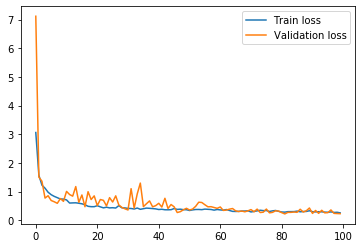

In [200]:
start = 0
plt.plot(history.history['loss'][start:])
plt.plot(history.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])
plt.savefig('loss_mask__vgg16_order_class.png')

In [196]:
f1 = open('train_loss_mask_vgg16_order_class.txt', 'w')
f1.writelines('%s\n' % i for i in history.history['loss'][start:])
f1.close()

f2 = open('vall_loss_mask_vgg16_order_class.txt', 'w')
f2.writelines('%s\n' % i for i in history.history['val_loss'][start:])
f2.close()

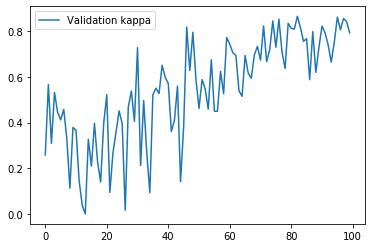

In [199]:
plt.plot(metrics0.get_data())
plt.legend(['Validation kappa']);
plt.savefig('kappa_mask_vgg16_order_class.png')

In [198]:
f4 = open('vall_kappa_vgg16_order_class.txt', 'w')
f4.writelines('%s\n' % i for i in metrics0.get_data())
f4.close()

# Продолжим обучать модель

In [210]:
model_mask.load_weights('100.hdf5')

In [211]:
history_101_150 = model_mask.fit_generator(fit_generator(dict_label_for_path=label_for_path_in_train, is_train=True),  # данные читаем функцией-генератором
        steps_per_epoch=11,  # число вызовов генератора за эпоху
        epochs=50,  # число эпох обучения
        validation_data=validation_data,
        callbacks=[metrics0,
            ModelCheckpoint(filepath='1{epoch:02d}.hdf5',
                            verbose=1,
                            save_best_only=False),
            ReduceLROnPlateau(monitor='output_1_loss',
                              factor=0.7,
                              verbose=1,
                              patience=8)]
                               )

Epoch 1/50
11/11 [==============================] - 278s 25s/step - loss: 0.2898 - output_1_loss: 0.2645 - output_2_loss: 254.0003 - val_loss: 0.2291 - val_output_1_loss: 0.2138 - val_output_2_loss: 136.0495
kappa_val = 0.7281

Epoch 00001: saving model to 101.hdf5
Epoch 2/50
11/11 [==============================] - 252s 23s/step - loss: 0.2782 - output_1_loss: 0.2549 - output_2_loss: 237.8495 - val_loss: 0.2047 - val_output_1_loss: 0.1917 - val_output_2_loss: 119.3130
kappa_val = 0.8226

Epoch 00002: saving model to 102.hdf5
Epoch 3/50
11/11 [==============================] - 252s 23s/step - loss: 0.2726 - output_1_loss: 0.2488 - output_2_loss: 237.3238 - val_loss: 0.2363 - val_output_1_loss: 0.2192 - val_output_2_loss: 149.7284
kappa_val = 0.7612

Epoch 00003: saving model to 103.hdf5
Epoch 4/50
11/11 [==============================] - 253s 23s/step - loss: 0.2750 - output_1_loss: 0.2483 - output_2_loss: 265.2200 - val_loss: 0.2181 - val_output_1_loss: 0.1998 - val_output_2_loss: 163

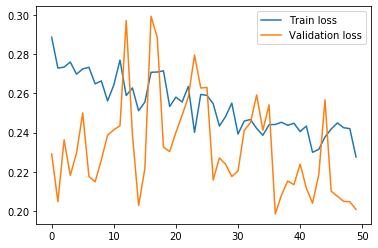

In [212]:
start = 0
plt.plot(history_101_150.history['loss'][start:])
plt.plot(history_101_150.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])
plt.savefig('loss_mask__vgg16_order_class_101_150.png')

In [214]:
start = 1

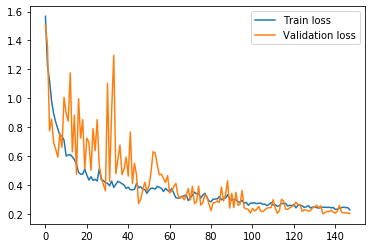

In [215]:
plt.plot(history.history['loss'][start:] + history_101_150.history['loss'][start:])
plt.plot(history.history['val_loss'][start:] + history_101_150.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])
plt.savefig('loss_mask__vgg16_order_class_1_150.png')

In [216]:
f1 = open('train_loss_mask_vgg16_order_class_101_150.txt', 'w')
f1.writelines('%s\n' % i for i in history_101_150.history['loss'][start:])
f1.close()

f2 = open('vall_loss_mask_vgg16_order_class_101_150.txt', 'w')
f2.writelines('%s\n' % i for i in history_101_150.history['val_loss'][start:])
f2.close()

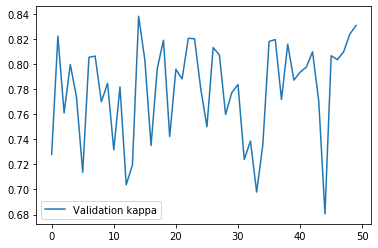

In [218]:
plt.plot(metrics0.get_data())
plt.legend(['Validation kappa']);
plt.savefig('kappa_mask_vgg16_order_class_101_150.png')

In [219]:
f4 = open('vall_kappa_vgg16_order_class_101_150.txt', 'w')
f4.writelines('%s\n' % i for i in metrics0.get_data())
f4.close()

## Подсчет качества

In [220]:
model_mask.load_weights('150.hdf5')

In [222]:
def get_true_labels_in_all_test(path_test):
    '''
    Возвращает правильные метки классов на тестовой выборке
    '''
    real_labels_in_all_test = list(map(lambda x: label_for_path_in_test[x], path_test))
    return real_labels_in_all_test

In [223]:
pred = model_mask.predict_generator(predict_generator(image_test), len(image_test), max_queue_size=500)

In [225]:
probas_labels = get_label_pred(pred[0], True)  # вектор вероятностей

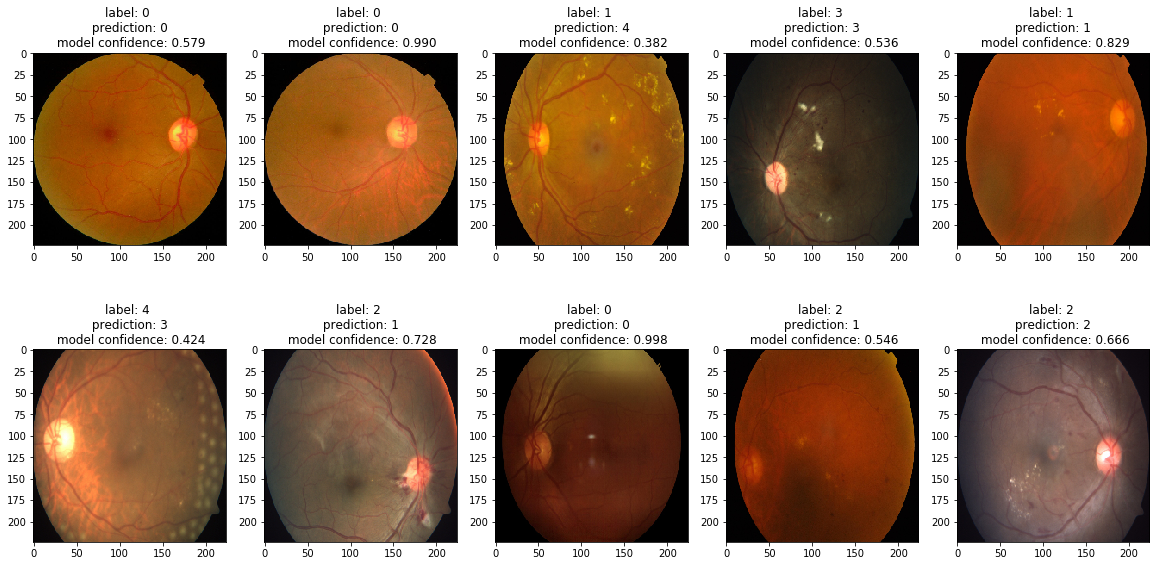

In [228]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(image_test[10:20], probas_labels[10:20]), 1):
    subplot = fig.add_subplot(math.ceil(i / 5), 5, i)
    plt.imshow(cv2.resize(plt.imread(path), IMG_SIZE));
    subplot.set_title('label: {} \n prediction: {} \n model confidence: {:.3f}'\
                      .format(label_for_path_in_test[path],
                              int(np.argmax(score)),
                             np.max(score)))

In [229]:
all_metrics(pred[0])

Каппа = 0.8314

-----------------------------------------

Точность: 0.7882

Точность в срезе по классам:
0: 0.9853
1: 0.4420
2: 0.7622
3: 0.2951
4: 0.4286

-----------------------------------------

Полнота: 0.7347

Полнота в срезе по классам:
0: 0.9533
1: 0.7921
2: 0.4579
3: 0.6792
4: 0.3000

-----------------------------------------

Энтропия: 0.9843


## Маска

In [230]:
def get_mask(test_path, prediction, koef):
    img = circle_crop(test_path, is_plot=True, blur=False)  # не нужен препроцессинг
    index = np.where(image_test == test_path)[0][0]  # номер картинки в тестовой выборке
    mask = cv2.resize(prediction[1][index], IMG_SIZE)
    mask = np.uint8(255 * koef * mask)  
    mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # RGB каналы
    img_mask = cv2.addWeighted(img, 1, mask, 0.3, 0)
    return img_mask, index

In [231]:
def plot_img_and_mask(test_path, prediction, koef):
    img = circle_crop(test_path, is_plot=True, blur=False)
    img_mask, index = get_mask(test_path, prediction, koef)
    label = get_label_pred(prediction[0])[index]
    fig = plt.figure(figsize=(20, 10))
    plt.title('label: {}, prediction: {}'.format(label_for_path_in_test[test_path], label))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img_mask)

Посмотрим на сегментационную маску для нескольких примеров

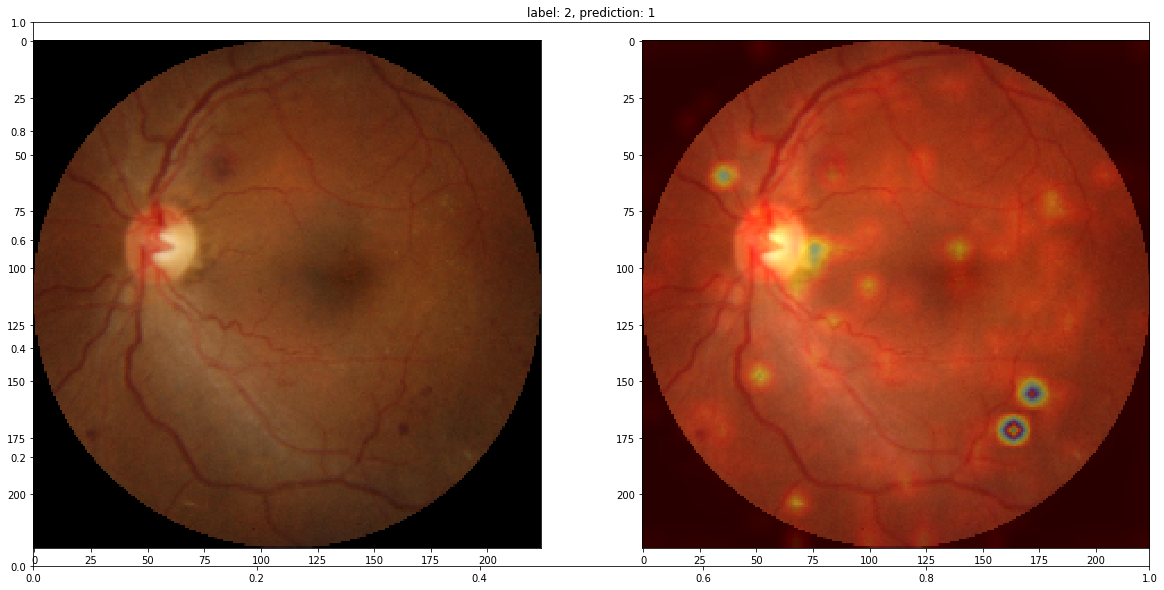

In [232]:
plot_img_and_mask(image_test[0], pred, 30)

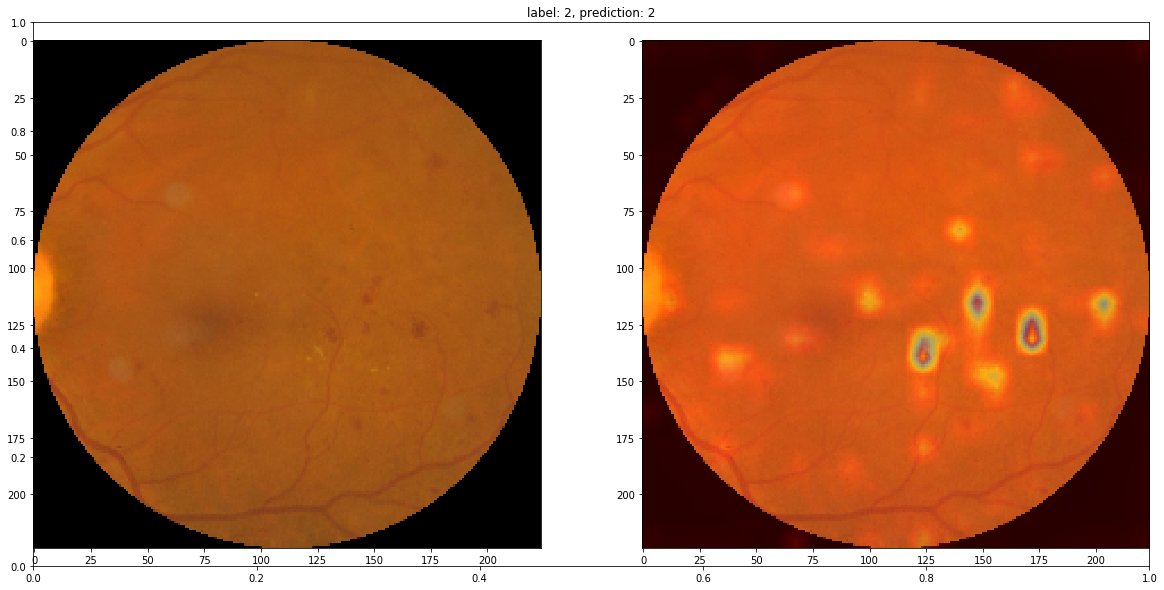

In [233]:
plot_img_and_mask(image_test[9], pred, 30)

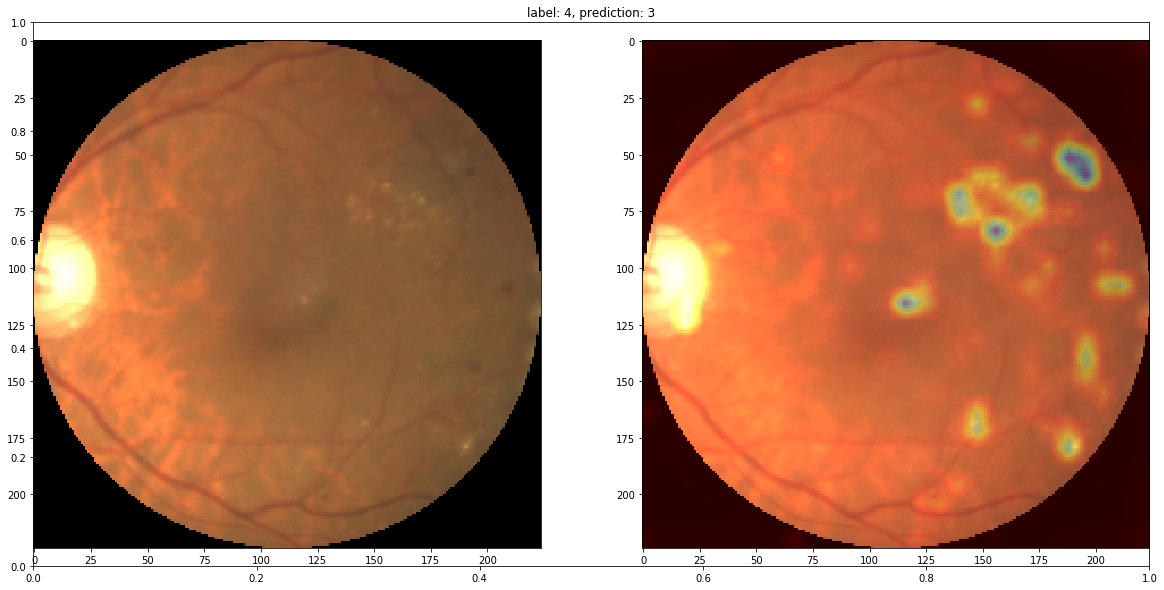

In [235]:
plot_img_and_mask(image_test[15], pred, 30)

Видим, что даже если модель и ошиблась в предсказании, то локализация проблемы поможет врачам с диагностикой.